In [48]:
# -*- coding: utf-8 -*-
"""
Created on Fri Oct 18 00:34:05 2019

@author: USER
"""
import pandas as pd          
import numpy as np          # For mathematical calculations
import matplotlib.pyplot as plt  # For plotting graphs
from datetime import datetime    # To access datetime
from pandas import Series        # To work on series
import matplotlib
import warnings                   # To ignore the warnings
warnings.filterwarnings("ignore")
from math import sqrt
from sklearn.metrics import mean_squared_error
from numpy import array

#Reading Data
df = pd.read_excel('Merged_pollution_dataset - wo 2016 17.xlsx')
df_bbsr = df[(df['City/Town/Village/Area'] == 'Bhubaneswar') | (df['City/Town/Village/Area'] == 'Bhubaneshwar')]

df_bbsr.dtypes

df_bbsr['RSPM/PM10'] = pd.to_numeric(df_bbsr['RSPM/PM10'], errors='coerce')
df_bbsr['SO2'] = pd.to_numeric(df_bbsr['SO2'], errors='coerce')
df_bbsr['NO2'] = pd.to_numeric(df_bbsr['NO2'], errors='coerce')
df_bbsr['SPM'] = pd.to_numeric(df_bbsr['NO2'], errors='coerce')

df_bbsr.dtypes

#Data Preprocessing
df_bbsr['Location of Monitoring Station'].replace('SPCB Building, Bhubaneshwar', 'OSPCB Bldg',inplace=True)
df_bbsr['Location of Monitoring Station'].replace('Capital Police Station, Bhubaneshwar', 'Capital Police Stn.',inplace=True)
df_bbsr['Location of Monitoring Station'].replace('IRC Vilage, Bhubaneshwar', 'IRC',inplace=True)
df_bbsr['Location of Monitoring Station'].replace('Chandrasekharpur. Bhubneswar', 'Chandrasekharpur',inplace=True)
df_bbsr['Location of Monitoring Station'].replace('Water works, Palasuni, Bhubneswar', 'Palasuni',inplace=True)
df_bbsr['Location of Monitoring Station'].replace('Patrapada, Bhubneswar', 'Patrapada',inplace=True)

df_bbsr_cps = df_bbsr[(df_bbsr['Location of Monitoring Station'] == 'Capital Police Stn.')]

#Initial Analysis
#Checking the datatypes of various columns
df_bbsr_cps.dtypes

#Converting object to Datetime
df_bbsr_cps.reset_index(inplace = True)
df_bbsr_cps = df_bbsr_cps.drop(['index'], axis = 1)
df_bbsr_cps['Sampling Date'] = pd.to_datetime(df_bbsr_cps['Sampling Date'], format='%Y-%m-%d %H:%M')
df_bbsr_cps['Sampling Date'] = pd.to_datetime(df_bbsr_cps['Sampling Date'], format='%Y-%m-%d %H:%M')


df_bbsr_cps.dtypes

#Setting default Plot Size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,8

print("SUCCESS!!")
df_bbsr_cps.head()

SUCCESS!!


,Stn Code,Sampling Date,State,City/Town/Village/Area,Location of Monitoring Station,Agency,Type of Location,SO2,NO2,RSPM/PM10,SPM
0,NaN,2005-04-01,Orissa,Bhubaneshwar,Capital Police Stn.,Odisha State Pollution Control Board,Residential and others,NaN,21.0,172.0,21.0
1,NaN,2005-06-01,Orissa,Bhubaneshwar,Capital Police Stn.,Odisha State Pollution Control Board,Residential and others,NaN,20.0,126.0,20.0
2,NaN,2005-09-01,Orissa,Bhubaneshwar,Capital Police Stn.,Odisha State Pollution Control Board,Residential and others,NaN,16.0,132.0,16.0
3,NaN,2005-12-01,Orissa,Bhubaneshwar,Capital Police Stn.,Odisha State Pollution Control Board,Residential and others,NaN,25.0,125.0,25.0
4,NaN,2005-01-14,Orissa,Bhubaneshwar,Capital Police Stn.,Odisha State Pollution Control Board,Residential and others,NaN,14.0,140.0,14.0


SUCCESS!!


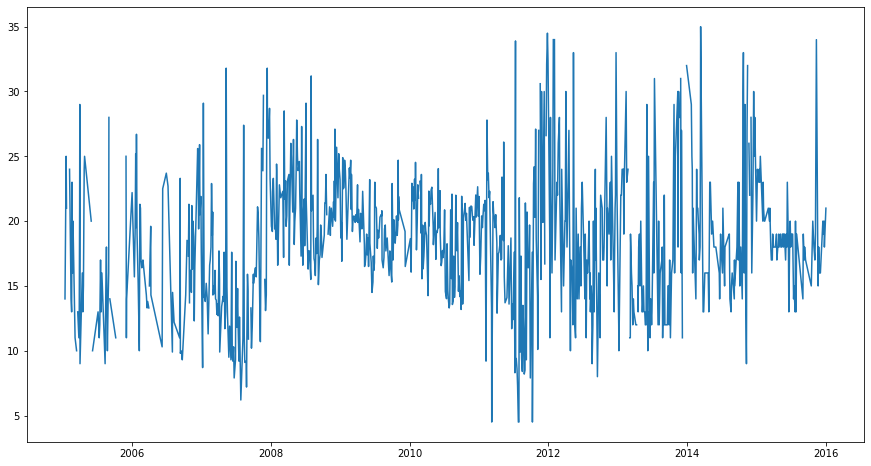

In [49]:
#Index Sorting
df_bbsr_cps = df_bbsr_cps.set_index(df_bbsr_cps['Sampling Date'])
df_bbsr_cps = df_bbsr_cps.sort_index()
# plt.plot(df_bbsr_cps['NO2'])

#Separating Year, Month, Day and Day of Week
df_bbsr_cps['year'] = df_bbsr_cps['Sampling Date'].dt.year 
df_bbsr_cps['month'] = df_bbsr_cps['Sampling Date'].dt.month 
df_bbsr_cps['day'] = df_bbsr_cps['Sampling Date'].dt.day
df_bbsr_cps['day_of_week'] = df_bbsr_cps['Sampling Date'].dt.dayofweek

#Determining Weekend
def weekend(row):
    if (row == 5) or (row == 6):
        return 1
    else:
        return 0

df_bbsr_cps['weekend'] = df_bbsr_cps['day_of_week'].apply(weekend)

#Outlier Removal
mean_cps = df_bbsr_cps['SPM'].mean()
std_dev_cps = df_bbsr_cps['SPM'].std() #Standard Deviation of SPM

df_bbsr_cps['SPM'][df_bbsr_cps['SPM'] > (mean_cps + 2.5*std_dev_cps)] = np.nan   #Replacing Outlier with "nan"
plt.plot(df_bbsr_cps['SPM'])
df_bbsr_cps.isna().sum()

df_bbsr_cps['SPM'] = df_bbsr_cps['SPM'].fillna(method = 'backfill')   #Replacing "nan" with the previous values

#Dummy Encoding
df_bbsr_cps = pd.get_dummies( df_bbsr_cps, columns = ['month', 'day_of_week'] )

print("SUCCESS!!")

In [50]:
#Creating Multi-features
xf = df_bbsr_cps[['weekend', 'month_1',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
       'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'SPM']]

xf.head()


,weekend,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,SPM
Sampling Date,,,,,,,,,,,,,,,,,,,,,
2005-01-14,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,14.0
2005-01-17,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,20.0
2005-01-20,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,25.0
2005-01-22,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,21.0
2005-01-25,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,29.0


In [51]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out-1
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)


# choose a number of time steps
n_steps_in, n_steps_out = 100, 21

mean_spm = xf['SPM'].mean()
std_spm = xf['SPM'].std()

#Feature Scaling
cols = ['weekend', 'month_1',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3',
       'day_of_week_4', 'day_of_week_5', 'day_of_week_6', 'SPM']

for field in cols:
    xf[field] = (xf[field] - xf[field].mean())/xf[field].std()


X, y = split_sequences(xf.values, n_steps_in, n_steps_out)

X_test, y_test = X[-1], y[-1]

X = np.delete(X, X.shape[0] - 1, 0)
y = np.delete(y, y.shape[0] - 1, 0)

# X = X.reshape(X.shape[0], X.shape[1], 1)
# y = y.reshape(y.shape[0], y.shape[1], 1)

n_features = X.shape[2]

print("SUCCESS!!")

SUCCESS!!


In [52]:
X.shape

(819, 100, 20)

In [53]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import LSTM
# from keras.layers import GRU
from keras.layers.normalization import BatchNormalization
from keras.layers import Bidirectional


model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu', input_shape=(n_steps_in, n_features)))
model.add(MaxPooling1D(pool_size=2))
# model.add(BatchNormalization())

model.add(Conv1D(filters=128, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# model.add(Flatten())
# model.add(Dense(50, activation='relu'))
model.add(Bidirectional(LSTM(50, return_sequences=True)))
model.add(Bidirectional(LSTM(50)))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

print('SUCCESS!!')

SUCCESS!!


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [54]:
from tensorflow.keras.callbacks import EarlyStopping

monitor = EarlyStopping(monitor='loss', min_delta=1e-3, patience=50, verbose=1, mode='auto',
        restore_best_weights=True)
model.fit(X, y, callbacks=[monitor], verbose=2, epochs=2000)

from sklearn.externals import joblib 
path = "/content/drive/My Drive/model_cnnbilstm_spm_30back.pkl"  
# Save the model as a pickle in a file 
joblib.dump(model, path)

Epoch 1/2000
 - 8s - loss: 0.9794
Epoch 2/2000
 - 5s - loss: 0.8857
Epoch 3/2000
 - 5s - loss: 0.7661
Epoch 4/2000
 - 5s - loss: 0.6846
Epoch 5/2000
 - 5s - loss: 0.6570
Epoch 6/2000
 - 5s - loss: 0.6434
Epoch 7/2000
 - 5s - loss: 0.6340
Epoch 8/2000
 - 5s - loss: 0.6293
Epoch 9/2000
 - 5s - loss: 0.6246
Epoch 10/2000
 - 5s - loss: 0.6189
Epoch 11/2000
 - 5s - loss: 0.6173
Epoch 12/2000
 - 5s - loss: 0.6125
Epoch 13/2000
 - 5s - loss: 0.6088
Epoch 14/2000
 - 5s - loss: 0.6082
Epoch 15/2000
 - 5s - loss: 0.6034
Epoch 16/2000
 - 5s - loss: 0.6030
Epoch 17/2000
 - 5s - loss: 0.6010
Epoch 18/2000
 - 5s - loss: 0.5986
Epoch 19/2000
 - 5s - loss: 0.5975
Epoch 20/2000
 - 5s - loss: 0.5952
Epoch 21/2000
 - 5s - loss: 0.5926
Epoch 22/2000
 - 5s - loss: 0.5913
Epoch 23/2000
 - 5s - loss: 0.5891
Epoch 24/2000
 - 5s - loss: 0.5863
Epoch 25/2000
 - 5s - loss: 0.5842
Epoch 26/2000
 - 5s - loss: 0.5817
Epoch 27/2000
 - 5s - loss: 0.5773
Epoch 28/2000
 - 5s - loss: 0.5763
Epoch 29/2000
 - 5s - loss: 0

['/content/drive/My Drive/model_cnnbilstm_spm_30back.pkl']

In [0]:
#Use only for the first time
from sklearn.externals import joblib 
  
# Save the model as a pickle in a file 
joblib.dump(model, 'model_cnn_bigru_spm.pkl') 
  
print("SUCCESS!!")

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


SUCCESS!!


In [0]:
from sklearn.externals import joblib 

# Load the model from the file 
model = joblib.load('model_cnn_lstm.pkl')

print("SUCCESS!!")

SUCCESS!!


In [55]:
x_input = array(X_test)
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=2)
print((yhat[0]*std_spm)+mean_spm)
print((y_test*std_spm)+mean_spm)

[11.788063 13.936279 20.75472  24.33404  16.880901 19.88051  18.537247
 19.357018 15.696371 17.75595  19.243193 24.941975 22.403612 19.265638
 29.552534 12.818317 20.812487 17.548727 14.4309   18.774307 18.567286]
[14. 19. 17. 18. 17. 15. 20. 18. 17. 19. 34. 18. 15. 18. 16. 16. 20. 19.
 20. 18. 21.]


In [56]:
X_test.shape

(100, 20)

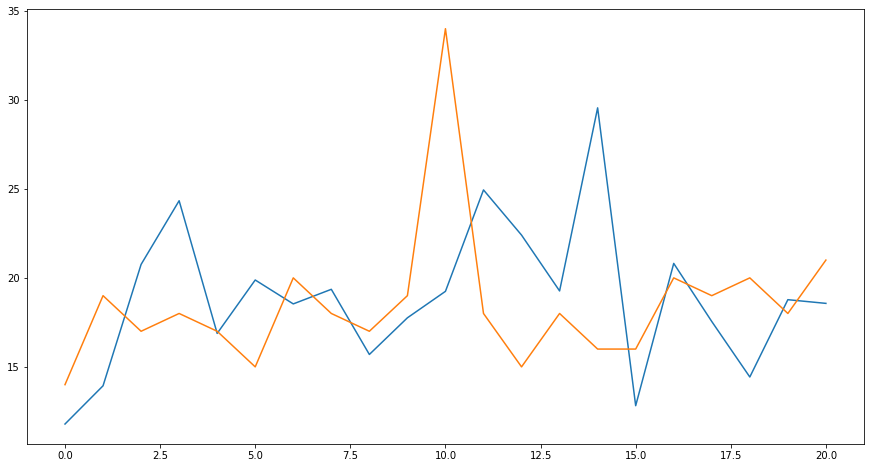

In [57]:
# fig, ax = plt.subplots()
plt.plot((yhat[0]*std_spm)+mean_spm)
plt.plot((y_test*std_spm)+mean_spm)
plt.show()

In [58]:
y_test = (y_test*std_spm)+mean_spm
yhat = (yhat[0]*std_spm)+mean_spm
print(yhat)
print(y_test)

[11.788063 13.936279 20.75472  24.33404  16.880901 19.88051  18.537247
 19.357018 15.696371 17.75595  19.243193 24.941975 22.403612 19.265638
 29.552534 12.818317 20.812487 17.548727 14.4309   18.774307 18.567286]
[14. 19. 17. 18. 17. 15. 20. 18. 17. 19. 34. 18. 15. 18. 16. 16. 20. 19.
 20. 18. 21.]


In [59]:
# from sklearn.metrics import mean_squared_error
# from math import sqrt

# rms = sqrt(mean_squared_error(y_test, yhat))
# print(rms)

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
def mean_absolute_percentage_error(y_true, y_pred): 
    # y_true, y_pred = check_arrays(y_true, y_pred)

    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


rms = sqrt(mean_squared_error(y_test, yhat))
print(rms)

mse = mean_squared_error(y_test, yhat)
print(mse)

mae = mean_absolute_error(y_test, yhat)
print(mae)

mape = mean_absolute_percentage_error(y_test, yhat)
print(mape)

5.658018182508906
32.01316975360138
4.08921936580113
21.924346764286547


In [60]:
x_ann = []

for inp_val in X:
  x_input_ann = inp_val.reshape((1, n_steps_in, n_features))
  y_newpred = model.predict(x_input_ann, verbose = 1)
  x_ann.append(y_newpred)
  
x_ann = array(x_ann)


1/1 [==============================] - 0s 76ms/step


In [61]:
x_ann

array([[[-0.6536507 , -0.03365047,  0.00549894, ..., -0.5507424 ,
         -1.0043174 , -1.2739247 ]],

       [[ 0.3038701 , -0.05226488, -0.99333763, ..., -0.826416  ,
         -1.2838782 , -0.45853728]],

       [[ 0.15310094, -1.2379946 , -0.29808345, ..., -1.313142  ,
         -0.5138317 , -0.13784108]],

       ...,

       [[ 0.20810166, -1.0369477 ,  0.19708332, ..., -0.42132547,
          0.27355617,  0.07616562]],

       [[-0.94225556,  0.25757056, -0.7850853 , ...,  0.41276303,
          0.2297276 ,  0.22691399]],

       [[-0.1425509 , -0.823539  ,  0.14326957, ...,  0.06893262,
          0.39789674, -0.38468003]]], dtype=float32)

In [62]:
x_ann_new = x_ann[:, 0, :]
x_ann_new.shape

(819, 21)

In [63]:
x_ann.shape #(410, 1, 30)
y.shape #(410, 30)

(819, 21)

In [64]:
model_new = Sequential()
model_new.add(Dense(100, input_dim=x_ann_new.shape[1], activation='relu',kernel_initializer='random_normal'))
model_new.add(Dense(50,activation='relu',kernel_initializer='random_normal'))
model_new.add(Dense(25,activation='relu',kernel_initializer='random_normal'))
model_new.add(Dense(n_steps_out))
model_new.compile(optimizer='adam', loss='mse')

print("SUCCESS!!")

SUCCESS!!


In [65]:
from tensorflow.keras.callbacks import EarlyStopping

monitor = EarlyStopping(monitor='loss', min_delta=1e-3, patience=50, verbose=1, mode='auto',
        restore_best_weights=True)
model_new.fit(x_ann_new, y, callbacks=[monitor], verbose=2, epochs=2000)

from sklearn.externals import joblib 
path = "/content/drive/My Drive/ann_model_cnnbiLSTMann_spm_100back.pkl"  
# Save the model as a pickle in a file 
joblib.dump(model, path) 
# # fit model
# model_new.fit(x_ann_new, y, epochs=1500, verbose=2)

Epoch 1/2000
 - 2s - loss: 0.9540
Epoch 2/2000
 - 0s - loss: 0.8011
Epoch 3/2000
 - 0s - loss: 0.6935
Epoch 4/2000
 - 0s - loss: 0.6023
Epoch 5/2000
 - 0s - loss: 0.5168
Epoch 6/2000
 - 0s - loss: 0.4514
Epoch 7/2000
 - 0s - loss: 0.4005
Epoch 8/2000
 - 0s - loss: 0.3560
Epoch 9/2000
 - 0s - loss: 0.3194
Epoch 10/2000
 - 0s - loss: 0.2882
Epoch 11/2000
 - 0s - loss: 0.2677
Epoch 12/2000
 - 0s - loss: 0.2490
Epoch 13/2000
 - 0s - loss: 0.2334
Epoch 14/2000
 - 0s - loss: 0.2175
Epoch 15/2000
 - 0s - loss: 0.2053
Epoch 16/2000
 - 0s - loss: 0.1929
Epoch 17/2000
 - 0s - loss: 0.1829
Epoch 18/2000
 - 0s - loss: 0.1719
Epoch 19/2000
 - 0s - loss: 0.1606
Epoch 20/2000
 - 0s - loss: 0.1519
Epoch 21/2000
 - 0s - loss: 0.1443
Epoch 22/2000
 - 0s - loss: 0.1381
Epoch 23/2000
 - 0s - loss: 0.1332
Epoch 24/2000
 - 0s - loss: 0.1308
Epoch 25/2000
 - 0s - loss: 0.1300
Epoch 26/2000
 - 0s - loss: 0.1293
Epoch 27/2000
 - 0s - loss: 0.1267
Epoch 28/2000
 - 0s - loss: 0.1263
Epoch 29/2000
 - 0s - loss: 0

['/content/drive/My Drive/ann_model_cnnbiLSTMann_spm_100back.pkl']

In [0]:
#Use only for the first time
from sklearn.externals import joblib 
  
# Save the model as a pickle in a file 
joblib.dump(model_new, 'ann_model_of__cnn_bigru_ann_spm.pkl') 
  
print("SUCCESS!!")

SUCCESS!!


In [66]:
y_test.shape
y_test_new = y_test.reshape(y_test.shape[0], -1)

y_test_new.shape
y_test

array([14., 19., 17., 18., 17., 15., 20., 18., 17., 19., 34., 18., 15.,
       18., 16., 16., 20., 19., 20., 18., 21.])

In [67]:
y_test_new = y_test_new.T
y_test_new

array([[14., 19., 17., 18., 17., 15., 20., 18., 17., 19., 34., 18., 15.,
        18., 16., 16., 20., 19., 20., 18., 21.]])

In [68]:
x_ann_new_input = array(y_test_new)
# x_ann_new_input = x_ann_new_input.reshape((1, n_steps_in, n_features))
yhat_new = model_new.predict(x_ann_new_input, verbose=2)
# print((yhat_new[0]*std_no2)+mean_no2)
# print((y_test_new*std_no2)+mean_no2)

print(yhat_new)
print(y_test_new)

[[12.154362  18.09274   15.167035  16.17088   13.742051  15.534932
  19.465824  14.7834635 15.39804   22.303635  25.622427  17.8131
  15.970466  15.828481  17.865637  18.003794  17.341366  20.666035
  17.04693   17.479876  20.841522 ]]
[[14. 19. 17. 18. 17. 15. 20. 18. 17. 19. 34. 18. 15. 18. 16. 16. 20. 19.
  20. 18. 21.]]


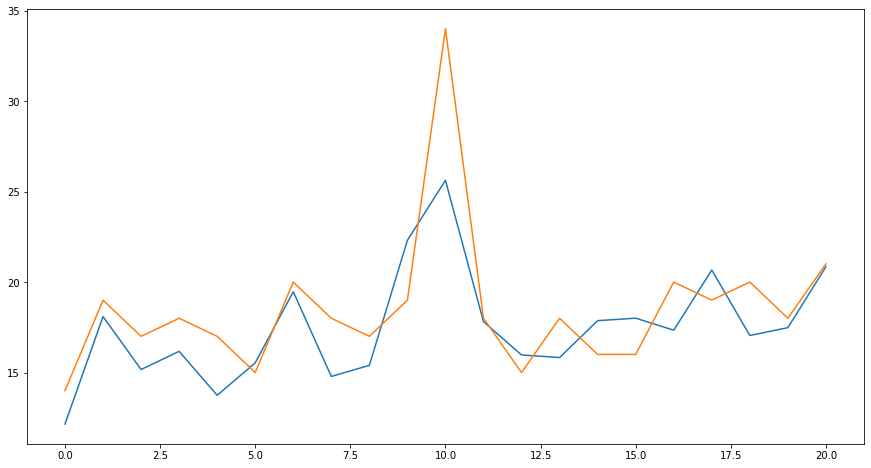

In [69]:
# fig, ax = plt.subplots()
plt.plot((yhat_new[0]))
plt.plot((y_test_new[0]))
plt.show()

In [70]:
# from sklearn.metrics import mean_squared_error
# from math import sqrt

# rms_new = sqrt(mean_squared_error(y_test_new, yhat_new))
# print(rms_new)

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
def mean_absolute_percentage_error(y_true, y_pred): 
    # y_true, y_pred = check_arrays(y_true, y_pred)

    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


rms_new = sqrt(mean_squared_error(y_test_new, yhat_new))
print(rms_new)

mse_new = mean_squared_error(y_test_new, yhat_new)
print(mse_new)

mae_new = mean_absolute_error(y_test_new, yhat_new)
print(mae_new)

mape_new = mean_absolute_percentage_error(y_test_new, yhat_new)
print(mape_new)

2.656340852879982
7.05614672667915
2.0188762573968795
10.373877353396436
